# First look at the SkySim5000 mass function
Authors : Constantin Payerne, Céline Combet

In [1]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import pickle as pkl
import scipy.integrate
import astropy.units as u
import GCRCatalogs

%matplotlib inline

In [2]:
skysim_cat = GCRCatalogs.load_catalog('skysim5000_v1.1.1_small')

In [3]:
cosmo_ss  = skysim_cat.cosmology

In [4]:
cosmo_ss

FlatLambdaCDM(H0=71.0 km / (Mpc s), Om0=0.2648, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=0.0448)

## Extract DM haloes from the catalog in a given mass and redshift range. 

In [5]:
# get list of halos in a given redshift and mass range 
mmin_extract = 1.e12 # Msun (M_fof)
zmin_extract = 0.
zmax_extract = 1.0

dm_halos = skysim_cat.get_quantities(['halo_mass','hostHaloMass','redshift','ra', 'dec', 'halo_id',
                                             'baseDC2/sod_halo_mass','baseDC2/sod_halo_radius'],
                                            filters=[f'halo_mass > {mmin_extract}','is_central==True',
                                            f'redshift>{zmin_extract}', f'redshift<{zmax_extract}'])

In [6]:
N_cl = len(dm_halos['halo_mass'])
print(f'There are {N_cl} halos in this mass (Mfof) and redshift range')

There are 300879 halos in this mass (Mfof) and redshift range


In [7]:
plt.scatter(dm_halos['ra'], dm_halos['dec'], marker='.', s=0.001)
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')

Text(0, 0.5, 'dec [deg]')

## Define a redshift and mass range for the comparison of data and prediction, and filter the data accordingly
NB: SkySim5000 M200c masses are in units of Msun/h

In [8]:
tmp = dm_halos['baseDC2/sod_halo_mass']/cosmo_ss.h # sod_halo_mass = M200,c in Msun/h, needs conversion
zmin = 0.
zmax = 1.
mmin = np.min(tmp[tmp>0]) # Msun. Filtering are there are some negative masses in the table
mmax = 1.e15 # Msun
filt1 = dm_halos['redshift'] >= zmin
filt2 = dm_halos['redshift'] <= zmax
 
filt3 = tmp >= mmin
filt4 = tmp < mmax
filt = filt1 * filt2 * filt3 * filt4

data = dm_halos['baseDC2/sod_halo_mass'][filt]/cosmo_ss.h # M200,c [Msun]

Total number of halos in z=[0.0,1.0] and M=[0.02607952137374648, 1.0] x 1e15 Msun = 101574


(array([3.4192e+04, 2.4348e+04, 1.6145e+04, 1.0479e+04, 6.8150e+03,
        4.1610e+03, 2.4960e+03, 1.4120e+03, 7.9200e+02, 4.0400e+02,
        1.8400e+02, 9.6000e+01, 3.6000e+01, 1.0000e+01, 4.0000e+00]),
 array([12.41629962, 12.58809836, 12.75989711, 12.93169586, 13.10349461,
        13.27529336, 13.4470921 , 13.61889085, 13.7906896 , 13.96248835,
        14.1342871 , 14.30608584, 14.47788459, 14.64968334, 14.82148209,
        14.99328084]),
 <BarContainer object of 15 artists>)

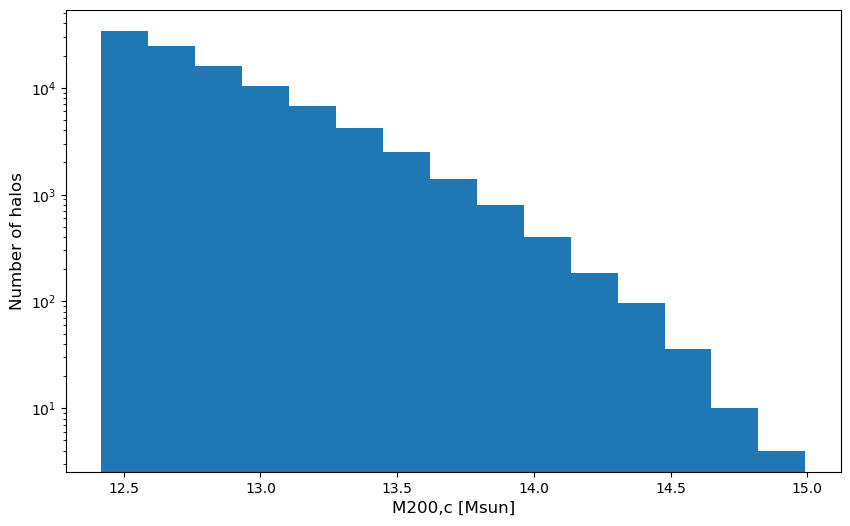

In [9]:
nbins = 15
plt.figure(figsize=(10,6))
hist = plt.hist(np.log10(data), bins=nbins)
plt.yscale('log')
plt.xlabel('M200,c [Msun]', size=12)
plt.ylabel('Number of halos', size=12)
print(f"Total number of halos in z=[{zmin},{zmax}] and M=[{mmin/1.e14}, {mmax/1.e15}] x 1e15 Msun = {len(data)}")
hist

## Prediction using CCL and the Tinker08 and Bocquet16 mass functions

In [10]:
# Define CCL Cosmology from SkySim cosmology
cosmo = ccl.Cosmology(Omega_c=cosmo_ss.Om0-cosmo_ss.Ob0, Omega_b=cosmo_ss.Ob0,
                      h=cosmo_ss.h, sigma8=cosmo_ss.sigma8, n_s=cosmo_ss.n_s, Neff=3.04)

print(cosmo)


<pyccl.cosmology.Cosmology>
	Neff    = 3.04
	Omega_b = 0.0448
	Omega_c = 0.21999999999999997
	h       = 0.71
	n_s     = 0.963
	sigma8  = 0.8
	extra_parameters =
	HASH_ACCURACY_PARAMS = 0x571a464b2020ea56


### Differential comoving volume

In [11]:
def dV_over_dOmega_dz(z):
    a = 1./(1. + z)
    da = ccl.background.angular_diameter_distance(cosmo, a) 
    E = ccl.background.h_over_h0(cosmo, a)
    return ((1.+z)**2)*(da**2)*ccl.physical_constants.CLIGHT_HMPC/cosmo['h']/E 

In [12]:
### Sanity check - comparison to the volume computed with Astropy
dV_over_dOmega_dz(0.3), cosmo_ss.differential_comoving_volume(0.3).value 

(5181343437.211351, 5181928585.256843)

### CCL mass functions

In [13]:
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
def tinker08(logm, z):
    mass = 10**(logm)
    hmf_200c = ccl.halos.hmfunc.MassFuncTinker08(mass_def=massdef)
    nm = hmf_200c.__call__(cosmo, mass, 1./(1+z))
    return nm # dn/dlog10M

def bocquet16(logm, z):
    mass = 10**(logm)
    hmf_200c = ccl.halos.hmfunc.MassFuncDespali16(mass_def=massdef)
    nm = hmf_200c.__call__(cosmo, mass, 1./(1+z))
    return nm # dn/dlog10M

In [14]:
def integrand_tinker08(logm,z):
    return tinker08(logm, z)*dV_over_dOmega_dz(z)

def integrand_bocquet16(logm,z):
    return bocquet16(logm, z)*dV_over_dOmega_dz(z)

### Solid angle of the `small` catalog = 50 deg2

Need to check if it is exactly 50 deg2 or if this has been rounded

In [15]:
DeltaOmega = 50 * np.pi**2/180**2

In [16]:
N_predicted_T08 = []

# Loop over mass bins defined by plt.hist and predict the corresponding number of haloes
# for Tinker 08
for i in np.arange(len(hist[0])):
    logmmin = np.log10(10**hist[1][i]) 
    logmmax = np.log10(10**hist[1][i+1])
    N_T08 = scipy.integrate.dblquad(integrand_tinker08, zmin, zmax, lambda x:logmmin, lambda x:logmmax, epsabs=1.e-4, epsrel=1.e-4)
    N_predicted_T08.append(N_T08[0]) 

In [17]:
N_predicted_B16 = []

# Loop over mass bins defined by plt.hist and predict the corresponding number of haloes
# for Bocquet 16
for i in np.arange(len(hist[0])):
    logmmin = np.log10(10**hist[1][i]) # Msun
    logmmax = np.log10(10**hist[1][i+1]) # Msun
    N_B16 = scipy.integrate.dblquad(integrand_bocquet16, zmin, zmax, lambda x:logmmin, lambda x:logmmax, epsabs=1.e-5, epsrel=1.e-4)
    N_predicted_B16.append(N_B16[0]) 

## Plot measured versus predicted number of haloes

In [18]:
np.log10(cosmo_ss.h)

-0.14874165128092473

In [19]:
cosmo_ss.h

0.71

Text(0, 0.5, 'Number of haloes')

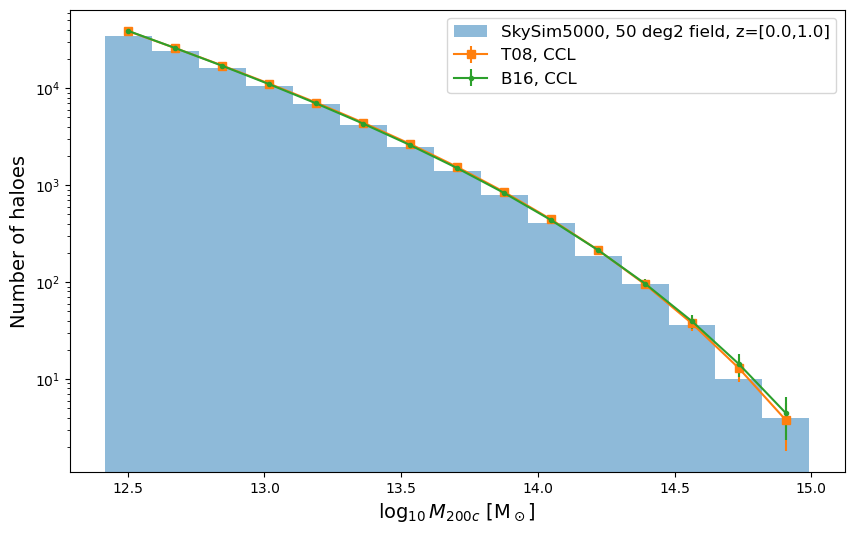

In [20]:
plt.figure(figsize=(10,6))
hist = plt.hist(np.log10(data), bins=nbins, 
                label=f'SkySim5000, 50 deg2 field, z=[{zmin},{zmax}]', histtype='bar', alpha=0.5)
bin_centers=[(hist[1][i]+hist[1][i+1])/2. for i in np.arange(len(hist[0]))]
plt.errorbar(bin_centers,np.array(N_predicted_T08)*DeltaOmega, (np.array(N_predicted_T08)*DeltaOmega)**.5, 
             marker = 's', label='T08, CCL')
plt.errorbar(bin_centers,np.array(N_predicted_B16)*DeltaOmega, (np.array(N_predicted_B16)*DeltaOmega)**.5, 
             marker = '.', label='B16, CCL')
plt.legend(fontsize=12)
plt.yscale('log')
plt.xlabel('$\log_{10}M_{200c}$ [M$_\odot$]', size=14)
plt.ylabel('Number of haloes', size=14)